In [2]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

comment = "Fit to covariance in sim"
nb_name = "nb_midpath_dynamo_covmod_sim"

In [3]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)
core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

In [4]:
core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


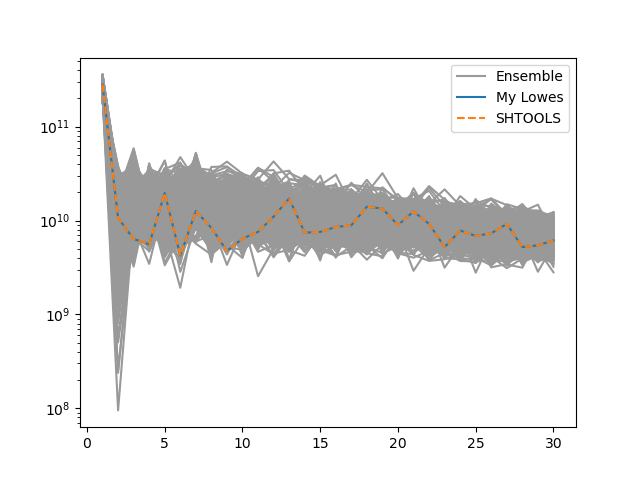

In [5]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

# g ensemble and parameters
g_core_ens = np.genfromtxt("mikkel_tools/models_shc/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.legend()
plt.show()

# New tapered cov

[]


<IPython.core.display.Javascript object>


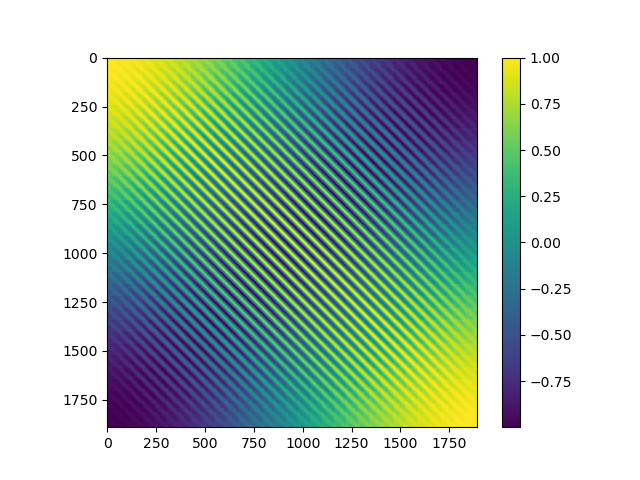

In [6]:
c_angdist = np.cos(mt_util.haversine(1, core.grid_phi.reshape(1,-1), 90-core.grid_theta.reshape(1,-1), 
                              core.grid_phi.reshape(-1,1), 90-core.grid_theta.reshape(-1,1)))

print(c_angdist[c_angdist>1])

plt.figure()
plt.imshow(c_angdist)
plt.colorbar()
plt.show()

In [7]:
tap_to = 501 # One extra for overlap between R_add and R
n_tap = n_max + tap_to - 1 # And one less as a result

tap_cos = np.cos(np.linspace(0,np.pi,20))+1
tap_cos_norm = ((tap_cos - np.min(tap_cos))/(np.max(tap_cos)-np.min(tap_cos))).reshape(-1,1)

# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_tap+1)+1)/(2*np.arange(1,n_tap+1)+1)

# Pn
Pn = []
for cmu in np.ravel(c_angdist):
    Pn.append(pyshtools.legendre.PlSchmidt(n_tap,cmu)[1:].reshape(-1,1))

Pn = np.array(Pn).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

<IPython.core.display.Javascript object>


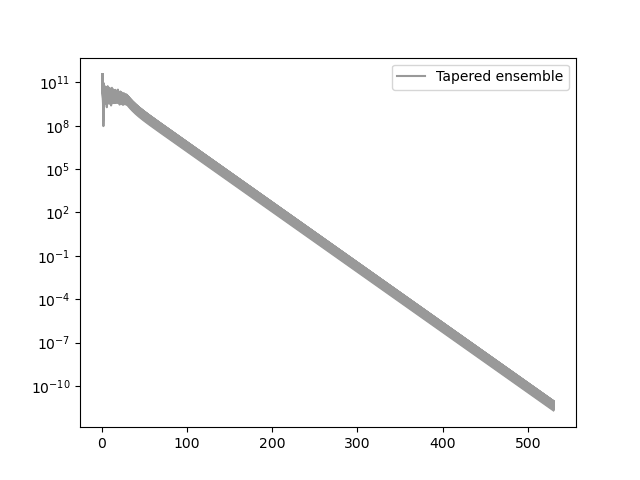

PD:  True


In [8]:
lin_exp = np.linspace(0,24,tap_to)
tap_exp = (0.5*np.exp(-5*lin_exp) + 0.5*np.exp(-2*lin_exp)).reshape(-1,1)


R_add = R[-1,:]*tap_exp
R_tap = np.vstack((R,R_add[1:,:]))

# Spectra
plt.figure()
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
    else:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
plt.legend()
plt.show()

C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

C_Br_model = C_Br[:,:,core.ens_idx]

PD = is_pos_def(C_Br_model)
print("PD: ", PD)

<IPython.core.display.Javascript object>


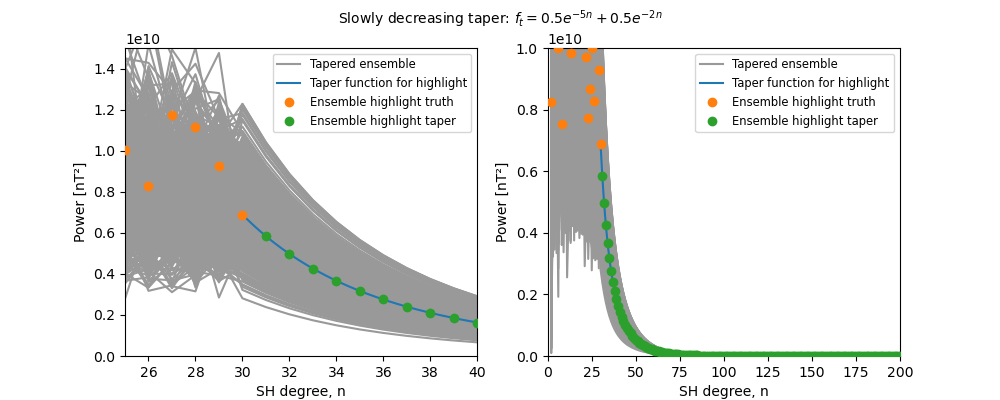

In [11]:
lin_exp = np.linspace(0,24,10000)
lin_deg = np.linspace(1,501,10000)
tap_exp = (0.5*np.exp(-5*lin_exp) + 0.5*np.exp(-2*lin_exp)).reshape(-1,1)
R_show = R[-1,:]*tap_exp

# Spectra
#fig, ax = plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        axes[0].plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        axes[0].plot(lin_deg+29,R_show[:,core.ens_idx],zorder = 10, label ="Taper function for highlight")
        axes[0].plot(np.arange(1,n_tap+1)[:30],R_tap[:30,core.ens_idx],"o",zorder = 11, label = "Ensemble highlight truth")
        axes[0].plot(np.arange(1,n_tap+1)[30:],R_tap[30:,core.ens_idx],"o",zorder = 11, label = "Ensemble highlight taper")
        
        axes[1].plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        axes[1].plot(lin_deg+29,R_show[:,core.ens_idx],zorder = 10, label ="Taper function for highlight")
        axes[1].plot(np.arange(1,n_tap+1)[:30],R_tap[:30,core.ens_idx],"o",zorder = 11, label = "Ensemble highlight truth")
        axes[1].plot(np.arange(1,n_tap+1)[30:],R_tap[30:,core.ens_idx],"o",zorder = 11, label = "Ensemble highlight taper")

        #axes[1].semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
    else:
        axes[0].plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        axes[1].plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        #axes[1].semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))

axes[0].set_xlim(25,40)
axes[0].set_ylim(0,1.5*10**10)
axes[1].set_xlim(0,200)
axes[1].set_ylim(0, 10**10)
axes[0].legend(fontsize="small")
axes[1].legend(fontsize="small")
axes[0].set_ylabel("Power [nT²]")
axes[0].set_xlabel("SH degree, n")
axes[1].set_ylabel("Power [nT²]")
axes[1].set_xlabel("SH degree, n")
fig.suptitle('Slowly decreasing taper: $f_t = 0.5e^{-5n} + 0.5e^{-2n}$', fontsize=10)
plt.show()

In [29]:
del Pn
del c_angdist

In [12]:
C_Br_model = np.mean(C_Br,axis=2)

<IPython.core.display.Javascript object>


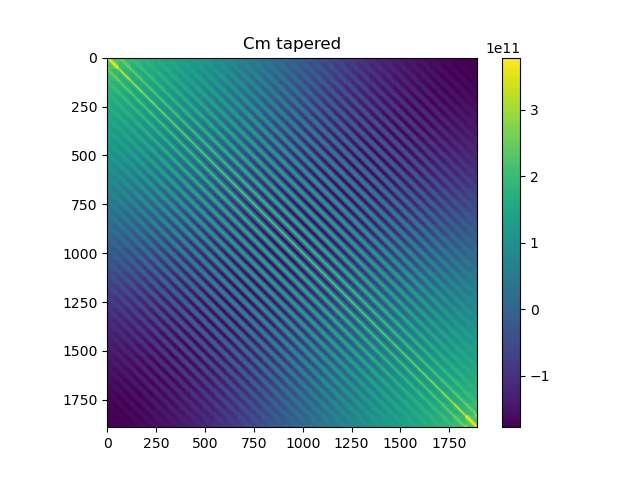

C_Br_model is pos def: True
All eigenvalues > 0: True
Number of negative eigenvalues: 0 / 1891


<IPython.core.display.Javascript object>


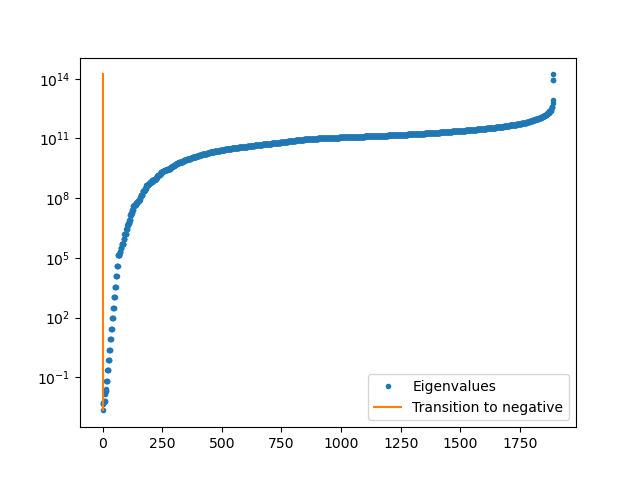

In [13]:
plt.figure()
plt.title("Cm tapered")
plt.imshow(C_Br_model)
plt.colorbar()
plt.show()

# Positive definite covariance?
core_eigval = spl.eigh(C_Br_model, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(C_Br_model))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()

# Synthetic sat

In [14]:
C_e_const = 2.0

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth

In [15]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [16]:
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = C_Br_model)

# SDSSIM

 |----------| 7.4%   realization nr. 0. Counter: 139/1891, Running error magnitude: 5.6

 |O---------| 12.9%   realization nr. 0. Counter: 243/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 52.214 seconds 
Total elapsed time: 0.870 minutes 
Variance: 467138323961.652
Mean: -17355.497
Max: 4201533.821
Min: -3319579.917
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 48.914 seconds 
Total elapsed time: 1.685 minutes 
Variance: 247639278111.480
Mean: 18960.950
Max: 3005641.203
Min: -1512312.399
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 50.753 seconds 
Total elapsed time: 2.531 minutes 
Variance: 407554379867.964
Mean: -21564.325
Max: 2746036.858
Min: -3254221.187
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 50.470 seconds 
Total elapsed time: 3.373 minutes 
Variance: 231962446731.065
Mean: 2142.445
Max: 1303925.544
Min: -3222915.591
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realizat

 |----------| 7.2%   realization nr. 34. Counter: 136/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.118 minutes 
Total elapsed time: 34.200 minutes 
Variance: 206304538071.267
Mean: -4378.526
Max: 3236135.803
Min: -3438096.096
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.122 minutes 
Total elapsed time: 35.323 minutes 
Variance: 326448637550.213
Mean: -14958.428
Max: 3037848.511
Min: -4864094.957
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.081 minutes 
Total elapsed time: 36.404 minutes 
Variance: 273602334232.662
Mean: -44948.869
Max: 3572802.827
Min: -4863511.457
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.124 minutes 
Total elapsed time: 37.528 minutes 
Variance: 255680973557.725
Mean: 27674.297
Max: 3868839.640
Min: -1430108.529
Run nr.: 38

 |OOOOOOOOOO| 100.0%  

 |----------| 6.9%   realization nr. 68. Counter: 131/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 68. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.132 minutes 
Total elapsed time: 1.184 hours 
Variance: 207072340066.622
Mean: -32292.628
Max: 1443114.078
Min: -1521893.980
Run nr.: 69

 |OOOOOOOOOO| 100.0%   realization nr. 69. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.123 minutes 
Total elapsed time: 1.202 hours 
Variance: 553108559598.409
Mean: -31542.999
Max: 3027964.587
Min: -4280308.861
Run nr.: 70

 |OOOOOOOOOO| 100.0%   realization nr. 70. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.099 minutes 
Total elapsed time: 1.221 hours 
Variance: 227960363828.292
Mean: -13091.545
Max: 1419449.864
Min: -3228233.478
Run nr.: 71

 |OOOOOOOOOO| 100.0%   realization nr. 71. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.034 minutes 
Total elapsed time: 1.238 hours 
Variance: 451631804963.767
Mean: -33819.028
Max: 4918812.868
Min: -4133116.269
Run nr.: 72

 |OOOOOOOOOO| 100.0%   realizati

 |----------| 7.5%   realization nr. 102. Counter: 141/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 102. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.046 minutes 
Total elapsed time: 1.790 hours 
Variance: 550135363626.398
Mean: 46840.014
Max: 4049820.815
Min: -4459508.097
Run nr.: 103

 |OOOOOOOOOO| 100.0%   realization nr. 103. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.038 minutes 
Total elapsed time: 1.807 hours 
Variance: 215964018830.370
Mean: 34578.838
Max: 4825553.542
Min: -2255709.615
Run nr.: 104

 |OOOOOOOOOO| 100.0%   realization nr. 104. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.046 minutes 
Total elapsed time: 1.824 hours 
Variance: 286700380658.275
Mean: 30403.927
Max: 3573964.654
Min: -1585205.188
Run nr.: 105

 |OOOOOOOOOO| 100.0%   realization nr. 105. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.036 minutes 
Total elapsed time: 1.842 hours 
Variance: 255062998280.469
Mean: -6326.329
Max: 4897509.580
Min: -1886501.890
Run nr.: 106

 |OOOOOOOOOO| 100.0%   reali

 |----------| 7.2%   realization nr. 136. Counter: 137/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 136. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 50.474 seconds 
Total elapsed time: 2.336 hours 
Variance: 638436086975.802
Mean: -13126.060
Max: 4865452.447
Min: -4831261.648
Run nr.: 137

 |OOOOOOOOOO| 100.0%   realization nr. 137. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 47.823 seconds 
Total elapsed time: 2.349 hours 
Variance: 507337379575.289
Mean: -24973.481
Max: 3610822.694
Min: -3802429.833
Run nr.: 138

 |OOOOOOOOOO| 100.0%   realization nr. 138. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.432 seconds 
Total elapsed time: 2.362 hours 
Variance: 312123389968.032
Mean: -27493.221
Max: 3521252.645
Min: -4865069.651
Run nr.: 139

 |OOOOOOOOOO| 100.0%   realization nr. 139. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.370 seconds 
Total elapsed time: 2.375 hours 
Variance: 232952335764.589
Mean: -8276.612
Max: 2005156.152
Min: -3548411.927
Run nr.: 140

 |OOOOOOOOOO| 100.0% 

 |----------| 7.2%   realization nr. 170. Counter: 136/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 170. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 53.003 seconds 
Total elapsed time: 2.791 hours 
Variance: 234289746296.870
Mean: 18450.006
Max: 1505938.518
Min: -3207532.874
Run nr.: 171

 |OOOOOOOOOO| 100.0%   realization nr. 171. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 52.497 seconds 
Total elapsed time: 2.806 hours 
Variance: 474943250839.109
Mean: -7490.061
Max: 4353468.781
Min: -2457156.991
Run nr.: 172

 |OOOOOOOOOO| 100.0%   realization nr. 172. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 46.988 seconds 
Total elapsed time: 2.819 hours 
Variance: 270466875680.098
Mean: -13626.208
Max: 1498301.859
Min: -2362779.223
Run nr.: 173

 |OOOOOOOOOO| 100.0%   realization nr. 173. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 46.225 seconds 
Total elapsed time: 2.832 hours 
Variance: 378381165038.068
Mean: -1491.538
Max: 3406701.630
Min: -2856499.597
Run nr.: 174

 |OOOOOOOOOO| 100.0%   

 |----------| 7.3%   realization nr. 204. Counter: 138/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 204. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.836 seconds 
Total elapsed time: 3.256 hours 
Variance: 209215938873.052
Mean: 17207.978
Max: 1442026.083
Min: -1934645.567
Run nr.: 205

 |OOOOOOOOOO| 100.0%   realization nr. 205. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.099 seconds 
Total elapsed time: 3.269 hours 
Variance: 241820646753.665
Mean: 21457.059
Max: 4873955.834
Min: -1577617.474
Run nr.: 206

 |OOOOOOOOOO| 100.0%   realization nr. 206. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.919 seconds 
Total elapsed time: 3.282 hours 
Variance: 290340897459.475
Mean: -53897.993
Max: 4857491.616
Min: -4905532.695
Run nr.: 207

 |OOOOOOOOOO| 100.0%   realization nr. 207. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.048 seconds 
Total elapsed time: 3.295 hours 
Variance: 174687833894.293
Mean: -2926.077
Max: 1510660.068
Min: -2586643.664
Run nr.: 208

 |OOOOOOOOOO| 100.0%   

 |----------| 7.9%   realization nr. 238. Counter: 149/1891, Running error magnitude: 5.8

 |O---------| 12.7%   realization nr. 238. Counter: 240/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 238. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.645 seconds 
Total elapsed time: 3.702 hours 
Variance: 285165775711.973
Mean: 29339.852
Max: 2191861.680
Min: -2366539.817
Run nr.: 239

 |OOOOOOOOOO| 100.0%   realization nr. 239. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 50.431 seconds 
Total elapsed time: 3.716 hours 
Variance: 294773672669.782
Mean: -25685.903
Max: 2094045.457
Min: -4766819.492
Run nr.: 240

 |OOOOOOOOOO| 100.0%   realization nr. 240. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.696 seconds 
Total elapsed time: 3.730 hours 
Variance: 430623250394.270
Mean: 11395.418
Max: 4867217.691
Min: -4567903.004
Run nr.: 241

 |OOOOOOOOOO| 100.0%   realization nr. 241. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.710 seconds 
Total elapsed time: 3.743 hours 
Variance: 286809909154.804
Mean: -42432.641
Max: 2295450.901
Min: -1583308.387
Run nr.: 242

 |OOOOOOOOOO| 100.0%  

 |----------| 7.6%   realization nr. 272. Counter: 143/1891, Running error magnitude: 5.4

 |OOOOOOOOOO| 100.0%   realization nr. 272. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.155 seconds 
Total elapsed time: 4.160 hours 
Variance: 357076074427.811
Mean: -31898.383
Max: 3665797.967
Min: -2598483.427
Run nr.: 273

 |OOOOOOOOOO| 100.0%   realization nr. 273. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.636 seconds 
Total elapsed time: 4.174 hours 
Variance: 212934797652.326
Mean: -32158.710
Max: 4096525.798
Min: -1639902.132
Run nr.: 274

 |OOOOOOOOOO| 100.0%   realization nr. 274. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 54.417 seconds 
Total elapsed time: 4.189 hours 
Variance: 273511874476.191
Mean: -20153.167
Max: 4271612.046
Min: -3010164.588
Run nr.: 275

 |OOOOOOOOOO| 100.0%   realization nr. 275. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 54.052 seconds 
Total elapsed time: 4.204 hours 
Variance: 274800399462.924
Mean: -5921.893
Max: 4849940.618
Min: -2214768.078
Run nr.: 276

 |OOOOOOOOOO| 100.0% 

 |----------| 7.1%   realization nr. 306. Counter: 134/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 306. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 52.337 seconds 
Total elapsed time: 4.620 hours 
Variance: 319191798389.201
Mean: -27379.100
Max: 4831432.879
Min: -1679302.819
Run nr.: 307

 |OOOOOOOOOO| 100.0%   realization nr. 307. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 52.279 seconds 
Total elapsed time: 4.634 hours 
Variance: 325658861265.969
Mean: -18854.049
Max: 4377255.465
Min: -3029061.251
Run nr.: 308

 |OOOOOOOOOO| 100.0%   realization nr. 308. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 59.555 seconds 
Total elapsed time: 4.651 hours 
Variance: 322154906916.652
Mean: -3634.734
Max: 3972429.010
Min: -4874386.611
Run nr.: 309

 |OOOOOOOOOO| 100.0%   realization nr. 309. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 52.872 seconds 
Total elapsed time: 4.665 hours 
Variance: 292102289383.281
Mean: 11119.710
Max: 4473490.748
Min: -2184531.286
Run nr.: 310

 |OOOOOOOOOO| 100.0%  

 |OOOOOOOOOO| 100.0%   realization nr. 340. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 48.942 seconds 
Total elapsed time: 5.084 hours 
Variance: 510563362813.358
Mean: -23166.414
Max: 4076867.822
Min: -3114070.612
Run nr.: 341

 |OOOOOOOOOO| 100.0%   realization nr. 341. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 48.727 seconds 
Total elapsed time: 5.098 hours 
Variance: 302397406890.769
Mean: 41488.130
Max: 4833827.353
Min: -1948790.469
Run nr.: 342

 |OOOOOOOOOO| 100.0%   realization nr. 342. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 48.661 seconds 
Total elapsed time: 5.111 hours 
Variance: 199903142847.485
Mean: -6496.070
Max: 1786947.570
Min: -2403217.241
Run nr.: 343

 |OOOOOOOOOO| 100.0%   realization nr. 343. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 48.590 seconds 
Total elapsed time: 5.125 hours 
Variance: 1139082161237.528
Mean: -10226.277
Max: 4123950.893
Min: -4220596.189
Run nr.: 344

 |OOOOOOOOOO| 100.0% 

 |----------| 7.2%   realization nr. 374. Counter: 136/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 374. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.765 seconds 
Total elapsed time: 5.523 hours 
Variance: 245068506064.452
Mean: 9923.319
Max: 3710837.821
Min: -1575298.257
Run nr.: 375

 |OOOOOOOOOO| 100.0%   realization nr. 375. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.689 seconds 
Total elapsed time: 5.535 hours 
Variance: 250474858815.847
Mean: -1637.069
Max: 2453875.956
Min: -1574221.531
Run nr.: 376

 |OOOOOOOOOO| 100.0%   realization nr. 376. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 55.505 seconds 
Total elapsed time: 5.551 hours 
Variance: 210570442639.394
Mean: 23323.367
Max: 3538618.197
Min: -1575574.279
Run nr.: 377

 |OOOOOOOOOO| 100.0%   realization nr. 377. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 54.358 seconds 
Total elapsed time: 5.566 hours 
Variance: 259580393855.618
Mean: 28392.115
Max: 3056303.055
Min: -4151689.939
Run nr.: 378

 |OOOOOOOOOO| 100.0%   re

 |----------| 7.8%   realization nr. 408. Counter: 148/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 408. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.167 seconds 
Total elapsed time: 5.994 hours 
Variance: 202986262818.267
Mean: -37219.448
Max: 2165033.655
Min: -4899098.354
Run nr.: 409

 |OOOOOOOOOO| 100.0%   realization nr. 409. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.148 seconds 
Total elapsed time: 6.006 hours 
Variance: 267859629352.707
Mean: 33239.338
Max: 2583752.083
Min: -3736100.101
Run nr.: 410

 |OOOOOOOOOO| 100.0%   realization nr. 410. Counter: 1891/1891, Running error magnitude: 6.0
Run time: 45.126 seconds 
Total elapsed time: 6.019 hours 
Variance: 1091551931465.748
Mean: -13927.029
Max: 4467393.863
Min: -4484963.001
Run nr.: 411

 |OOOOOOOOOO| 100.0%   realization nr. 411. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 44.347 seconds 
Total elapsed time: 6.031 hours 
Variance: 264763556643.859
Mean: 9466.364
Max: 3945067.873
Min: -1653118.819
Run nr.: 412

 |OOOOOOOOOO| 100.0%  

 |----------| 6.9%   realization nr. 442. Counter: 130/1891, Running error magnitude: 5.9

 |O---------| 12.1%   realization nr. 442. Counter: 228/1891, Running error magnitude: 5.9

 |OOOOOOOOOO| 100.0%   realization nr. 442. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 45.018 seconds 
Total elapsed time: 6.449 hours 
Variance: 747353706846.926
Mean: 414.923
Max: 4436294.321
Min: -3593017.059
Run nr.: 443

 |OOOOOOOOOO| 100.0%   realization nr. 443. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.536 seconds 
Total elapsed time: 6.462 hours 
Variance: 170911631459.699
Mean: 15544.593
Max: 1451410.266
Min: -1241422.774
Run nr.: 444

 |OOOOOOOOOO| 100.0%   realization nr. 444. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.384 seconds 
Total elapsed time: 6.475 hours 
Variance: 249770226025.767
Mean: 18662.167
Max: 3756558.292
Min: -3451297.011
Run nr.: 445

 |OOOOOOOOOO| 100.0%   realization nr. 445. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 45.458 seconds 
Total elapsed time: 6.487 hours 
Variance: 565661295932.870
Mean: 38627.098
Max: 3682384.377
Min: -3313481.275
Run nr.: 446

 |OOOOOOOOOO| 100.0%   rea

 |----------| 7.8%   realization nr. 476. Counter: 147/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 476. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.852 seconds 
Total elapsed time: 6.903 hours 
Variance: 275083368887.894
Mean: 17985.193
Max: 2671638.397
Min: -4825428.606
Run nr.: 477

 |OOOOOOOOOO| 100.0%   realization nr. 477. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.683 seconds 
Total elapsed time: 6.916 hours 
Variance: 504515023740.177
Mean: -27041.259
Max: 4576676.189
Min: -3332635.855
Run nr.: 478

 |OOOOOOOOOO| 100.0%   realization nr. 478. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.717 seconds 
Total elapsed time: 6.929 hours 
Variance: 203887033797.630
Mean: 55690.886
Max: 2354348.673
Min: -1477844.796
Run nr.: 479

 |OOOOOOOOOO| 100.0%   realization nr. 479. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.737 seconds 
Total elapsed time: 6.941 hours 
Variance: 438469562822.172
Mean: 23659.387
Max: 3650258.119
Min: -3986519.276
Run nr.: 480

 |OOOOOOOOOO| 100.0%   

 |----------| 6.6%   realization nr. 510. Counter: 124/1891, Running error magnitude: 5.6

 |O---------| 11.4%   realization nr. 510. Counter: 215/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 510. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.059 seconds 
Total elapsed time: 7.372 hours 
Variance: 298526154819.570
Mean: -48692.555
Max: 4808326.317
Min: -1774932.724
Run nr.: 511

 |OOOOOOOOOO| 100.0%   realization nr. 511. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 51.719 seconds 
Total elapsed time: 7.386 hours 
Variance: 219128154644.723
Mean: -9730.498
Max: 1497195.979
Min: -2219798.255
Run nr.: 512

 |OOOOOOOOOO| 100.0%   realization nr. 512. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.871 seconds 
Total elapsed time: 7.399 hours 
Variance: 259236515054.389
Mean: 3718.407
Max: 1850549.082
Min: -3267010.949
Run nr.: 513

 |OOOOOOOOOO| 100.0%   realization nr. 513. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.991 seconds 
Total elapsed time: 7.412 hours 
Variance: 232647306294.756
Mean: -8063.136
Max: 1871760.658
Min: -1754504.123
Run nr.: 514

 |OOOOOOOOOO| 100.0%   r

 |----------| 7.2%   realization nr. 544. Counter: 137/1891, Running error magnitude: 5.6

 |O---------| 12.4%   realization nr. 544. Counter: 235/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 544. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.608 seconds 
Total elapsed time: 7.816 hours 
Variance: 215793896452.736
Mean: -9341.684
Max: 1937797.699
Min: -4438214.876
Run nr.: 545

 |OOOOOOOOOO| 100.0%   realization nr. 545. Counter: 1891/1891, Running error magnitude: 6.0
Run time: 46.354 seconds 
Total elapsed time: 7.829 hours 
Variance: 2086591925047.129
Mean: 74866.782
Max: 4872253.266
Min: -3897682.068
Run nr.: 546

 |OOOOOOOOOO| 100.0%   realization nr. 546. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.285 seconds 
Total elapsed time: 7.842 hours 
Variance: 355649256832.622
Mean: 10191.984
Max: 2670464.870
Min: -3694144.147
Run nr.: 547

 |OOOOOOOOOO| 100.0%   realization nr. 547. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.402 seconds 
Total elapsed time: 7.856 hours 
Variance: 222650038762.874
Mean: -49395.035
Max: 1569709.246
Min: -1735497.567
Run nr.: 548

 |OOOOOOOOOO| 100.0%  

 |----------| 7.5%   realization nr. 578. Counter: 141/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 578. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 53.031 seconds 
Total elapsed time: 8.280 hours 
Variance: 360862110205.279
Mean: 2583.686
Max: 2695772.332
Min: -4855508.479
Run nr.: 579

 |OOOOOOOOOO| 100.0%   realization nr. 579. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 51.342 seconds 
Total elapsed time: 8.294 hours 
Variance: 600909566711.703
Mean: 3351.733
Max: 4336810.041
Min: -3571474.682
Run nr.: 580

 |OOOOOOOOOO| 100.0%   realization nr. 580. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 51.082 seconds 
Total elapsed time: 8.308 hours 
Variance: 312772838699.796
Mean: 30658.840
Max: 3099424.142
Min: -3329428.141
Run nr.: 581

 |OOOOOOOOOO| 100.0%   realization nr. 581. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 52.085 seconds 
Total elapsed time: 8.323 hours 
Variance: 300930713710.152
Mean: -38037.074
Max: 3275356.204
Min: -3263268.517
Run nr.: 582

 |OOOOOOOOOO| 100.0%   re

 |----------| 7.8%   realization nr. 612. Counter: 147/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 612. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 51.305 seconds 
Total elapsed time: 8.735 hours 
Variance: 212916975507.365
Mean: -3299.274
Max: 3657306.801
Min: -1518537.436
Run nr.: 613

 |OOOOOOOOOO| 100.0%   realization nr. 613. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 44.971 seconds 
Total elapsed time: 8.748 hours 
Variance: 317528155723.742
Mean: 2678.251
Max: 2687250.121
Min: -4542977.039
Run nr.: 614

 |OOOOOOOOOO| 100.0%   realization nr. 614. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.583 seconds 
Total elapsed time: 8.760 hours 
Variance: 277168345002.115
Mean: 31605.163
Max: 3068298.560
Min: -2439168.542
Run nr.: 615

 |OOOOOOOOOO| 100.0%   realization nr. 615. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.027 seconds 
Total elapsed time: 8.773 hours 
Variance: 231654989651.679
Mean: 9073.163
Max: 3436555.943
Min: -1856470.473
Run nr.: 616

 |OOOOOOOOOO| 100.0%   rea

 |----------| 7.6%   realization nr. 646. Counter: 144/1891, Running error magnitude: 5.5

 |O---------| 12.5%   realization nr. 646. Counter: 237/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 646. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 44.315 seconds 
Total elapsed time: 9.175 hours 
Variance: 445324507927.775
Mean: 37666.255
Max: 3604423.142
Min: -2763034.206
Run nr.: 647

 |OOOOOOOOOO| 100.0%   realization nr. 647. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.932 seconds 
Total elapsed time: 9.187 hours 
Variance: 234193166326.903
Mean: -4279.411
Max: 1425346.909
Min: -3859812.334
Run nr.: 648

 |OOOOOOOOOO| 100.0%   realization nr. 648. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.205 seconds 
Total elapsed time: 9.200 hours 
Variance: 301799957649.475
Mean: 8004.167
Max: 3609487.235
Min: -4808281.934
Run nr.: 649

 |OOOOOOOOOO| 100.0%   realization nr. 649. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.086 seconds 
Total elapsed time: 9.213 hours 
Variance: 248963632408.688
Mean: -36054.042
Max: 2331513.456
Min: -4016076.965
Run nr.: 650

 |OOOOOOOOOO| 100.0%   r

 |----------| 7.8%   realization nr. 680. Counter: 147/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 680. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 47.220 seconds 
Total elapsed time: 9.642 hours 
Variance: 217285540881.687
Mean: -38695.977
Max: 2094003.959
Min: -3247769.138
Run nr.: 681

 |OOOOOOOOOO| 100.0%   realization nr. 681. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 46.837 seconds 
Total elapsed time: 9.655 hours 
Variance: 232123737142.168
Mean: -126.804
Max: 2094223.892
Min: -2583289.968
Run nr.: 682

 |OOOOOOOOOO| 100.0%   realization nr. 682. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.770 seconds 
Total elapsed time: 9.668 hours 
Variance: 277602790985.729
Mean: 9928.219
Max: 3957277.122
Min: -2262580.332
Run nr.: 683

 |OOOOOOOOOO| 100.0%   realization nr. 683. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.493 seconds 
Total elapsed time: 9.681 hours 
Variance: 212681328782.627
Mean: -34279.694
Max: 1466018.074
Min: -2054660.249
Run nr.: 684

 |OOOOOOOOOO| 100.0%   r

 |----------| 6.2%   realization nr. 714. Counter: 118/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 714. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 51.158 seconds 
Total elapsed time: 10.096 hours 
Variance: 433386083838.757
Mean: -23360.016
Max: 3735369.001
Min: -4105795.077
Run nr.: 715

 |OOOOOOOOOO| 100.0%   realization nr. 715. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.335 seconds 
Total elapsed time: 10.109 hours 
Variance: 194776713915.472
Mean: 19344.644
Max: 1550610.940
Min: -1781337.977
Run nr.: 716

 |OOOOOOOOOO| 100.0%   realization nr. 716. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.871 seconds 
Total elapsed time: 10.122 hours 
Variance: 242449233711.113
Mean: 31848.198
Max: 1596560.379
Min: -3002993.860
Run nr.: 717

 |OOOOOOOOOO| 100.0%   realization nr. 717. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 47.069 seconds 
Total elapsed time: 10.135 hours 
Variance: 263209253949.097
Mean: -7169.148
Max: 4867203.134
Min: -1934981.745
Run nr.: 718

 |OOOOOOOOOO| 100.0

 |----------| 6.7%   realization nr. 748. Counter: 127/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 748. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 50.196 seconds 
Total elapsed time: 10.548 hours 
Variance: 483376483055.219
Mean: 15091.426
Max: 3336380.203
Min: -3061101.227
Run nr.: 749

 |OOOOOOOOOO| 100.0%   realization nr. 749. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.591 seconds 
Total elapsed time: 10.560 hours 
Variance: 295712966151.038
Mean: -10084.621
Max: 1372923.802
Min: -3305806.389
Run nr.: 750

 |OOOOOOOOOO| 100.0%   realization nr. 750. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.699 seconds 
Total elapsed time: 10.573 hours 
Variance: 558153310134.702
Mean: -13778.590
Max: 4845438.446
Min: -4518487.768
Run nr.: 751

 |OOOOOOOOOO| 100.0%   realization nr. 751. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.537 seconds 
Total elapsed time: 10.586 hours 
Variance: 234178802474.148
Mean: -25972.126
Max: 1414430.326
Min: -1961769.632
Run nr.: 752

 |OOOOOOOOOO| 100

 |----------| 7.7%   realization nr. 782. Counter: 146/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 782. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.129 seconds 
Total elapsed time: 10.988 hours 
Variance: 702377170101.667
Mean: 425.148
Max: 3438129.383
Min: -3907551.233
Run nr.: 783

 |OOOOOOOOOO| 100.0%   realization nr. 783. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.790 seconds 
Total elapsed time: 11.000 hours 
Variance: 318877718234.562
Mean: -52562.271
Max: 4832426.808
Min: -2243535.342
Run nr.: 784

 |OOOOOOOOOO| 100.0%   realization nr. 784. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 45.920 seconds 
Total elapsed time: 11.013 hours 
Variance: 217942686164.960
Mean: -7739.716
Max: 2746405.021
Min: -1928798.186
Run nr.: 785

 |OOOOOOOOOO| 100.0%   realization nr. 785. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 54.142 seconds 
Total elapsed time: 11.028 hours 
Variance: 221349456690.380
Mean: 30375.659
Max: 3798718.480
Min: -1526546.483
Run nr.: 786

 |OOOOOOOOOO| 100.0% 

 |----------| 7.7%   realization nr. 816. Counter: 145/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 816. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 45.595 seconds 
Total elapsed time: 11.452 hours 
Variance: 475809347179.204
Mean: -8448.622
Max: 3929216.909
Min: -2696331.318
Run nr.: 817

 |OOOOOOOOOO| 100.0%   realization nr. 817. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 53.262 seconds 
Total elapsed time: 11.467 hours 
Variance: 307693842101.395
Mean: 412.790
Max: 4036819.454
Min: -4869860.364
Run nr.: 818

 |OOOOOOOOOO| 100.0%   realization nr. 818. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 52.887 seconds 
Total elapsed time: 11.482 hours 
Variance: 468193741471.594
Mean: -35134.961
Max: 4868498.417
Min: -5476831.056
Run nr.: 819

 |OOOOOOOOOO| 100.0%   realization nr. 819. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 47.474 seconds 
Total elapsed time: 11.495 hours 
Variance: 599906258534.119
Mean: -15554.770
Max: 3497837.032
Min: -4158990.650
Run nr.: 820

 |OOOOOOOOOO| 100.0%

 |----------| 7.4%   realization nr. 850. Counter: 139/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 850. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.211 seconds 
Total elapsed time: 11.922 hours 
Variance: 289265991029.001
Mean: -31025.775
Max: 2327106.724
Min: -4292813.047
Run nr.: 851

 |OOOOOOOOOO| 100.0%   realization nr. 851. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 46.929 seconds 
Total elapsed time: 11.935 hours 
Variance: 529950490821.943
Mean: 37689.727
Max: 4807313.711
Min: -3195853.580
Run nr.: 852

 |OOOOOOOOOO| 100.0%   realization nr. 852. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 50.352 seconds 
Total elapsed time: 11.949 hours 
Variance: 217222531406.962
Mean: 5690.745
Max: 2481076.496
Min: -2734121.502
Run nr.: 853

 |OOOOOOOOOO| 100.0%   realization nr. 853. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 52.414 seconds 
Total elapsed time: 11.964 hours 
Variance: 221575427543.173
Mean: -11829.968
Max: 1534320.465
Min: -1407915.887
Run nr.: 854

 |OOOOOOOOOO| 100.0

 |----------| 7.9%   realization nr. 884. Counter: 150/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 884. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 48.218 seconds 
Total elapsed time: 12.389 hours 
Variance: 328884565506.754
Mean: 7160.028
Max: 3038312.847
Min: -2872504.765
Run nr.: 885

 |OOOOOOOOOO| 100.0%   realization nr. 885. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.870 seconds 
Total elapsed time: 12.402 hours 
Variance: 220536265045.487
Mean: 19960.175
Max: 2899179.724
Min: -1511463.123
Run nr.: 886

 |OOOOOOOOOO| 100.0%   realization nr. 886. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 49.008 seconds 
Total elapsed time: 12.416 hours 
Variance: 332368655019.841
Mean: -18966.136
Max: 4792149.582
Min: -4805498.678
Run nr.: 887

 |OOOOOOOOOO| 100.0%   realization nr. 887. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 50.420 seconds 
Total elapsed time: 12.430 hours 
Variance: 338656189191.054
Mean: 7861.719
Max: 3229814.565
Min: -2632865.054
Run nr.: 888

 |OOOOOOOOOO| 100.0% 

 |----------| 7.6%   realization nr. 918. Counter: 144/1891, Running error magnitude: 5.6

 |O---------| 12.5%   realization nr. 918. Counter: 236/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 918. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 45.500 seconds 
Total elapsed time: 12.851 hours 
Variance: 179327640227.516
Mean: 4300.601
Max: 1657270.835
Min: -1507862.197
Run nr.: 919

 |OOOOOOOOOO| 100.0%   realization nr. 919. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 50.910 seconds 
Total elapsed time: 12.865 hours 
Variance: 353599428936.308
Mean: -33840.439
Max: 4830296.445
Min: -2159034.650
Run nr.: 920

 |OOOOOOOOOO| 100.0%   realization nr. 920. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 48.098 seconds 
Total elapsed time: 12.879 hours 
Variance: 449201585320.641
Mean: -15616.003
Max: 2770612.119
Min: -2144165.494
Run nr.: 921

 |OOOOOOOOOO| 100.0%   realization nr. 921. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 45.455 seconds 
Total elapsed time: 12.891 hours 
Variance: 240909813505.701
Mean: -24266.711
Max: 1958141.581
Min: -2661720.588
Run nr.: 922

 |OOOOOOOOOO| 100.

 |----------| 7.6%   realization nr. 952. Counter: 143/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 952. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 53.279 seconds 
Total elapsed time: 13.314 hours 
Variance: 208216416429.232
Mean: 13659.892
Max: 3210313.661
Min: -1335697.177
Run nr.: 953

 |OOOOOOOOOO| 100.0%   realization nr. 953. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 52.296 seconds 
Total elapsed time: 13.329 hours 
Variance: 245651501149.377
Mean: 1370.189
Max: 1534048.880
Min: -2855202.881
Run nr.: 954

 |OOOOOOOOOO| 100.0%   realization nr. 954. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 52.988 seconds 
Total elapsed time: 13.343 hours 
Variance: 466644020088.265
Mean: 71421.418
Max: 4201239.451
Min: -2820232.498
Run nr.: 955

 |OOOOOOOOOO| 100.0%   realization nr. 955. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 53.163 seconds 
Total elapsed time: 13.358 hours 
Variance: 235382139472.865
Mean: 37028.945
Max: 2802071.156
Min: -1364228.786
Run nr.: 956

 |OOOOOOOOOO| 100.0% 

 |----------| 7.9%   realization nr. 986. Counter: 150/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 986. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.384 seconds 
Total elapsed time: 13.761 hours 
Variance: 212434835769.504
Mean: 10267.644
Max: 2313042.269
Min: -2274306.833
Run nr.: 987

 |OOOOOOOOOO| 100.0%   realization nr. 987. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 46.433 seconds 
Total elapsed time: 13.774 hours 
Variance: 805374792547.532
Mean: 21283.792
Max: 4496404.962
Min: -4001328.170
Run nr.: 988

 |OOOOOOOOOO| 100.0%   realization nr. 988. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 46.520 seconds 
Total elapsed time: 13.787 hours 
Variance: 194361642006.118
Mean: 25236.689
Max: 1389470.197
Min: -1560938.603
Run nr.: 989

 |OOOOOOOOOO| 100.0%   realization nr. 989. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 50.843 seconds 
Total elapsed time: 13.801 hours 
Variance: 227644018662.208
Mean: -40357.650
Max: 3115051.029
Min: -1532482.204
Run nr.: 990

 |OOOOOOOOOO| 100.0

<IPython.core.display.Javascript object>


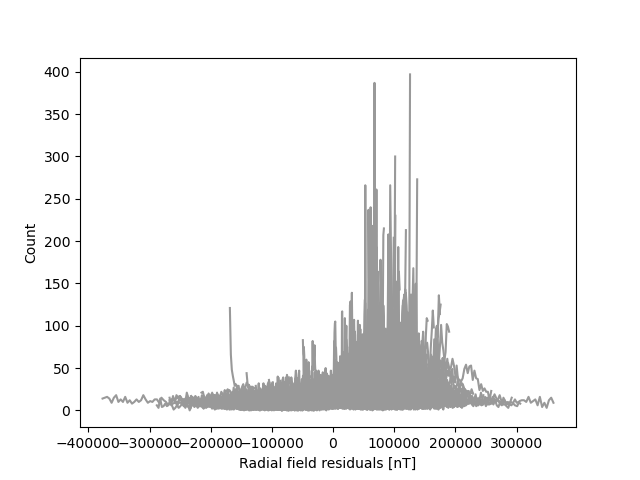

In [17]:
N_sim = 1000
core.target_var = np.max(C_Br_model)
#core.target_var = np.var(core.data)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = True, solve_cho = True)

In [18]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [19]:
#core.covmod_lsq_equiv(s_sat.data, C_Br_model, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


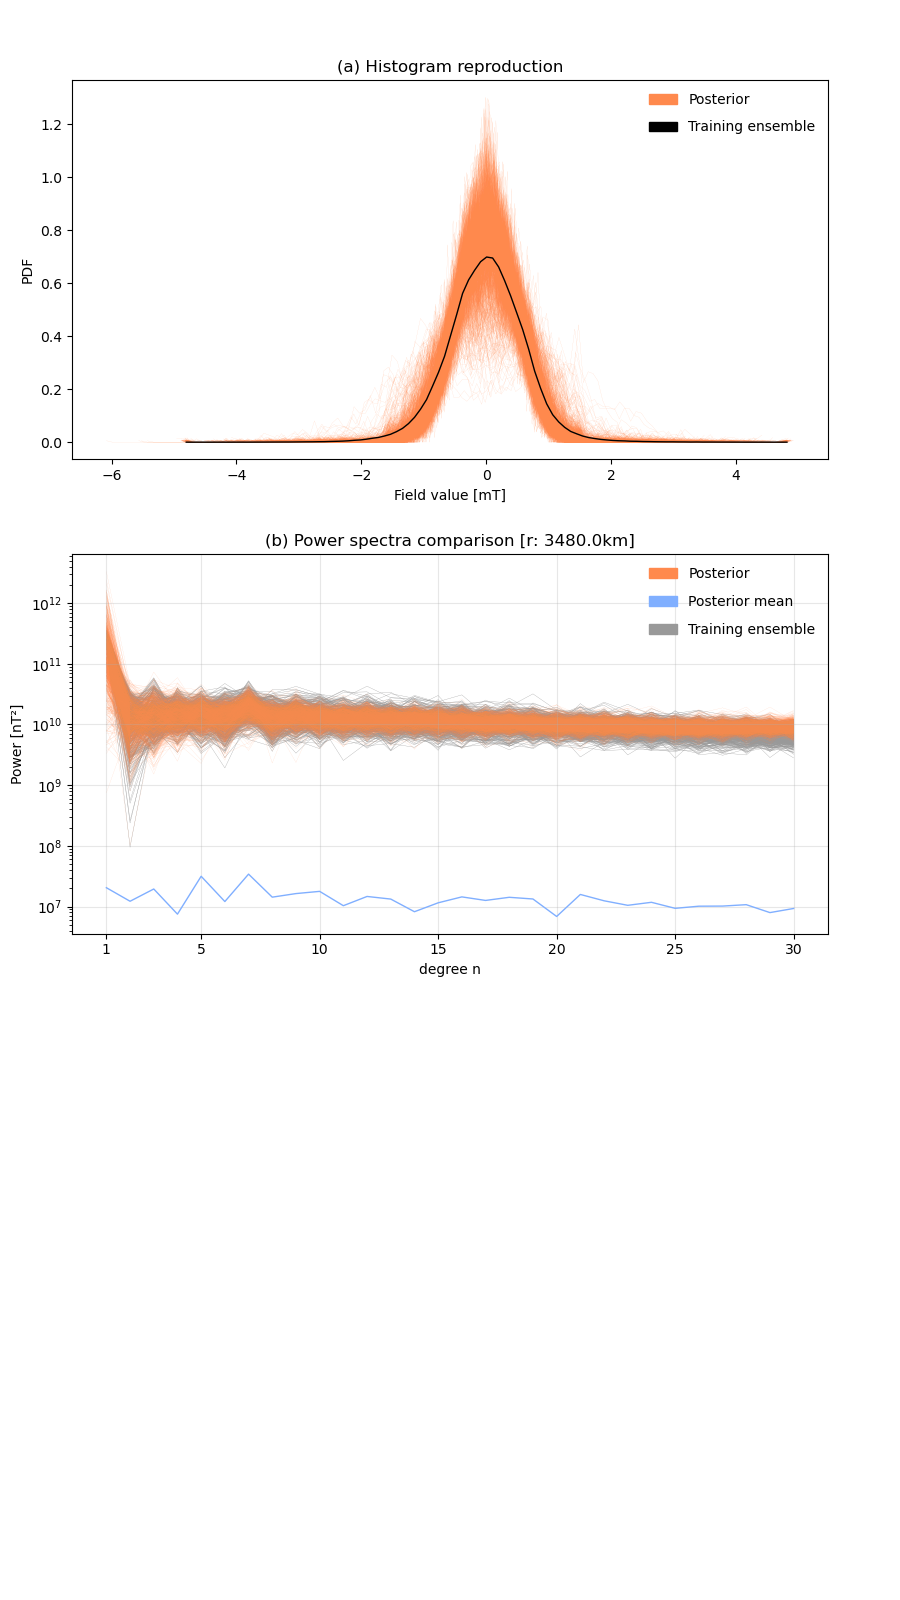

In [28]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, spec_lwidth = 0.05, label_fontsize = "medium",
                              res_use = False, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = True, hist_density = True,
                              hist_bins = 101, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "core_sh30_ens", save_dpi = 300)

In [25]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


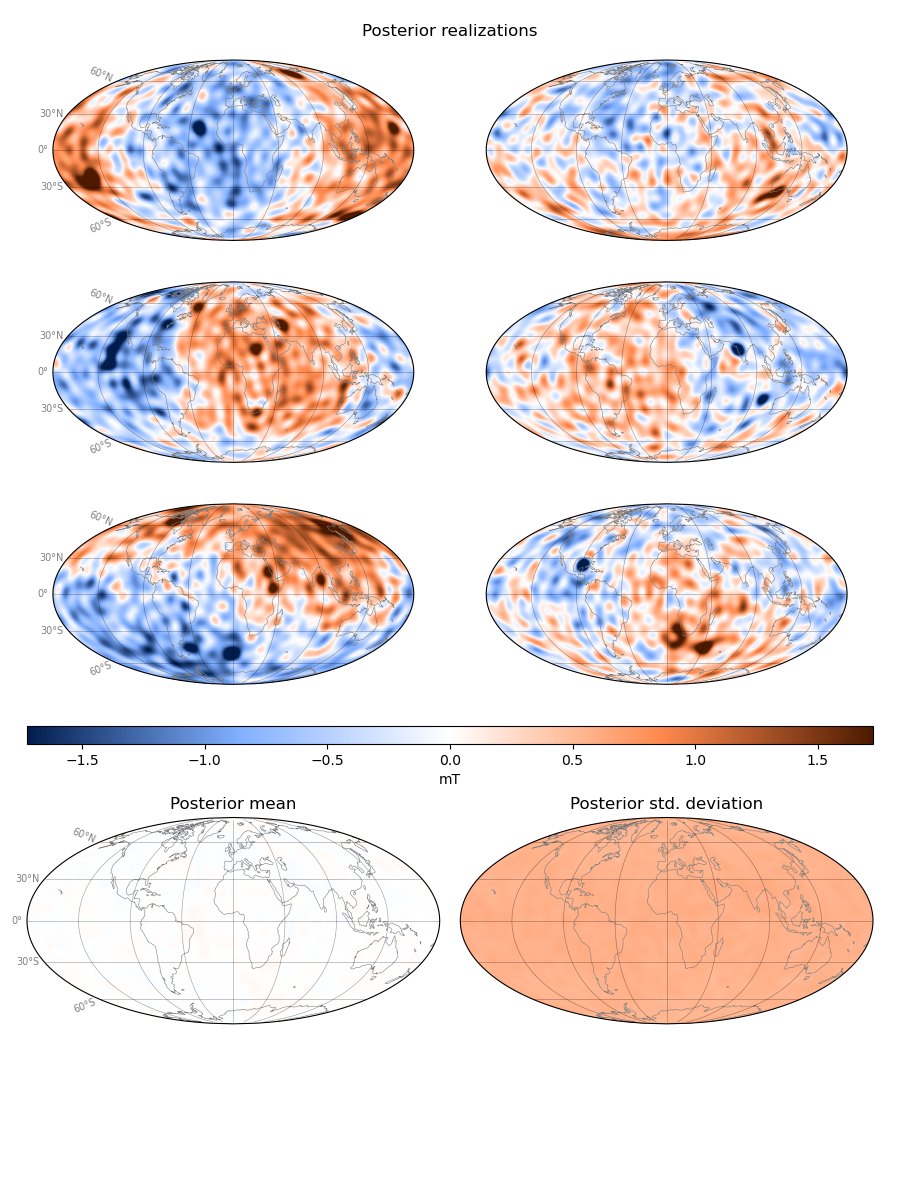

In [27]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = None, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
